# LSTM Time Series Explorations with Keras

This is a very short exploration into applying LSTM techniques using the Keras library. Code and content is based on several cool blog posts and papers; see references section for more info.

There are further notes on LSTM theory and Keras in an accompanying Slideshare: https://www.slideshare.net/RalphSchlosser/lstm-tutorial

**FIXMEs**: 
* Compare and contrast different parametrizations or architectures.
* Consolidate helper functions, simplify.

## Exchange Rates Data
 
In this example we wish to make forcasts on a  time series of exchange rates.
 
The time series data forcast can be modeled as a univariate regression-type problem, concretely let ${X_t}$ denote the number of airline passengers in month $t$. Then: 
 
$$
X_t = f(X_{t-1}, \Theta)
$$
 
which we aim to solve using the a simple LSTM neural network. 

Here $X_t$ is Dollar value of Turkish Lira at time step $t$, $X_{t-1}$ denotes  Dollar value at the previous time step, and $\Theta$ refers to all the other model parameters, including LSTM hyperparameters.

*Note*: For better readability, in the code for this as well as the next example, the predicted new value at time step $t$ is written as `Y`. 

### Loading and plotting the data

In [1]:
import warnings
import itertools
from math import sqrt
from datetime import datetime
from numpy import concatenate
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional, GRU

#import statsmodels.api as sm
#import fbprophet as fb
#import pyflux as pf

import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
py.init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load data
data = pd.read_excel('usd_alis.xlsx', date_parser=[0])

In [3]:
# first five rows
data.head()

,tarih,usd_alis
0,03-01-2005,1.3363
1,04-01-2005,1.3383
2,05-01-2005,1.3427
3,06-01-2005,1.3775
4,07-01-2005,1.4000


In [4]:
data.tail()

,tarih,usd_alis
4966,09-08-2018,5.2813
4967,10-08-2018,5.3988
4968,11-08-2018,NaN
4969,12-08-2018,NaN
4970,13-08-2018,5.9389


Here, we have a univariate data set which records the exchange rates for each days.

Let's now plot the time series of the data in order to get some ideas about underlying trends, seasonality etc.

In [5]:
data.dtypes

tarih        object
usd_alis    float64
dtype: object

In [6]:
data['tarih'] = pd.to_datetime(data.tarih, format='%d-%m-%Y')

In [7]:
data.dtypes

tarih       datetime64[ns]
usd_alis           float64
dtype: object

In [8]:
data.index = data.tarih

In [9]:
data['usd_alis'].interpolate(method='linear', inplace=True)

In [10]:
data.tail()

,tarih,usd_alis
tarih,,
2018-08-09,2018-08-09,5.281300
2018-08-10,2018-08-10,5.398800
2018-08-11,2018-08-11,5.578833
2018-08-12,2018-08-12,5.758867
2018-08-13,2018-08-13,5.938900


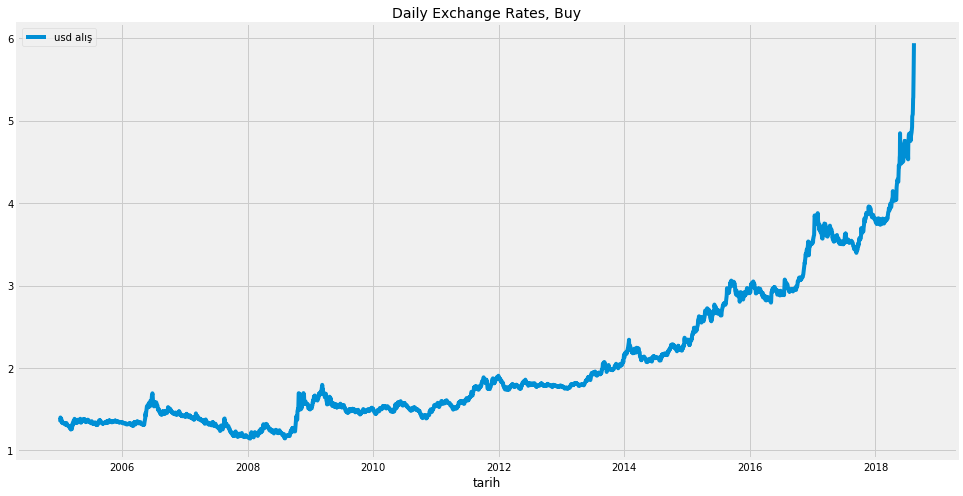

In [11]:
fig = plt.figure(figsize=(15,8))
data.usd_alis.plot(label='usd alış')
plt.legend(loc='best')
plt.title('Daily Exchange Rates, Buy', fontsize=14)
plt.show()

We could also consider de-trending the time series and applying further "cleaning" techniques, which would be a prerequisite e.g. in an *ARIMA* setting.

However, for simplicity reasons we will just proceed with the data as is.

The only transformations we'll be doing are:

* Scale data to the $(0, 1)$ interval for increased numerical stability.
* Re-shape the data so we have one column as **response** (called $Y$ in the code) and another one as **predictor** variable (called $X in the code).

### Building the LSTM model


In [12]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

#### Data preparation

In [13]:
from sklearn.preprocessing import MinMaxScaler
values = data['usd_alis'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

# print a few values
dataset[0:5]

array([[0.0399249 ],
       [0.04034211],
       [0.0412599 ],
       [0.048519  ],
       [0.05321236]], dtype=float32)

#### Split into test / training data

As usual, the data gets split into training and test data so we can later assess how well the final model performs. 

Again, this could be much improved, e.g. using CV and more sophisticated steps to select the "best" model.

In [14]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))


Number of entries (training set, test set): (2982, 1989)


#### Get data into shape to use in Keras

In [15]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [16]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(2980, 1)
New training data shape:
(2980, 1, 1)


#### Build simple LSTM model on training data

The LSTM architecture here consists of:

* One input layer.
* One LSTM layer of 100 blocks.
* One `Dense` layer to produce a single output.
* Use MSE as loss function.

Many different architectures could be considered. But this is just a quick test, so we'll keep things nice and simple.

In [17]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(100, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 30, 
              batch_size = 1, 
              verbose = 1)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/30
2980/2980 [==============================] - 8s 3ms/step - loss: 1.1995e-04
Epoch 2/30
2980/2980 [==============================] - 8s 3ms/step - loss: 9.6722e-06
Epoch 3/30
2980/2980 [==============================] - 9s 3ms/step - loss: 9.5579e-06
Epoch 4/30
2980/2980 [==============================] - 7s 3ms/step - loss: 9.0437e-06
Epoch 5/30
2980/2980 [==============================] - 7s 3ms/step - loss: 9.1336e-06
Epoch 6/30
2980/2980 [==============================] - 8s 3ms/step - loss: 8.7129e-06
Epoch 7/30
2980/2980 [==============================] - 8s 3ms/step - loss: 9.0282e-06
Epoch 8/30
2980/2980 [==============================] - 9s 3ms/step - loss: 8.7584e-06
Epoch 9/30
2980/2980 [==============================] - 9s 3ms/step - loss: 8.4351e-06
Epoch 10/30
2980/2980 [==============================] - 8s 3ms/step - 

### Results
#### Predictions and model evaluation

As can be seen below, already the simple model performs not too poorly. The advantage of using the RMSE is that it's in the same unit as the original data.

In [18]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 0.01 RMSE
Test data score: 0.10 RMSE


#### Plotting original data, predictions, and forecast

With a plot we can compare the predicted vs. actual exchange rate figures.

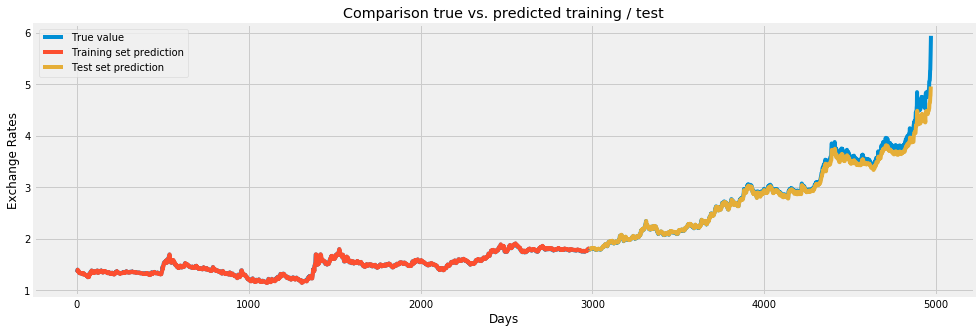

In [19]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Exchange Rates")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()


### Next steps and things to explore

* Work with de-trended, stationary time series. Does it improve performance?
* Different window size (multiple regression).
* LSTM architecture, i.e. more layers, neurons etc.
* Impact of various hyperparameters in LSTM network on prediction accuracy.
* Model selection steps to find the "best" model.

## References and links

* A good reference summary cards:  https://www.slideshare.net/TessFerrandez/notes-from-coursera-deep-learning-courses-by-andrew-ng
* A good dive into deep learning: http://en.diveintodeeplearning.org/
* Another great post: https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f
* Example 2 code adapted from the above: https://github.com/kmsravindra/ML-AI-experiments/tree/master/AI/LSTM-time_series
* Good paper comparing different time series modeling techniques, including LSTM: https://arxiv.org/pdf/1705.09137.pdf
* Another excellent paper: https://arxiv.org/pdf/1705.05690.pdf
* Brilliant LSTM course by Nando de Freitas: https://www.youtube.com/watch?v=56TYLaQN4N8
* A good visual understanding of Recurrent Neural Networks: http://colah.github.io/posts/2015-08-Understanding-LSTMs/